# Clustering Game of Thrones Characters

The goal of this project was to find 'clusters' of characters for Game of Thrones based on a character's vocabulary.

In [1]:
import numpy as np
import pandas as pd
import pprint
import csv
import sys
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt

In [2]:
d = {}
csv.field_size_limit(sys.maxsize)
with open('got_lines.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        lines = row['lines'].split(';')
        if len(lines)>75:
            d[row['character']] = lines

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
from nltk.stem.snowball import SnowballStemmer
import contractions
stemmer = SnowballStemmer('english')

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    fixed_text = contractions.fix(text)
    tokens = [word for sent in nltk.sent_tokenize(fixed_text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    fixed_text = contractions.fix(text)
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(fixed_text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in d:
    lines = ' '.join(d[i])
    allwords_stemmed = tokenize_and_stem(lines) #for each item in tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(lines)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(vocab_frame)

          words
mmh         mmh
it           it
is           is
true       true
what       what
...         ...
messag  message
from       from
the         the
night     night
king       king

[176757 rows x 1 columns]


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

characters = list(d.keys())
documents = [' '.join(d[i]) for i in d]
%time tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

print(tfidf_matrix.shape)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 13.2 s, sys: 115 ms, total: 13.3 s
Wall time: 13.4 s
(53, 801)


In [5]:
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

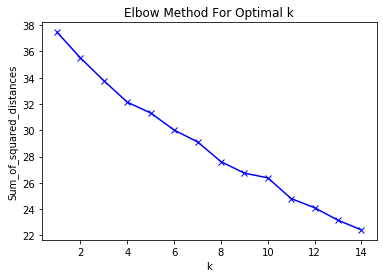

In [7]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
joblib.dump(km,  'doc_cluster.pkl')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 699 ms, sys: 14.8 ms, total: 714 ms
Wall time: 752 ms


['doc_cluster.pkl']

In [9]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [10]:
groups = { 'character': characters, 'documents': documents, 'cluster': clusters,}

frame = pd.DataFrame(groups, index = [clusters] , columns = ['character', 'cluster'])

In [11]:
frame['cluster'].value_counts()

2    27
3    13
0     5
4     4
1     4
Name: cluster, dtype: int64

In [12]:
print('Top terms per cluster:')
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print(f'Cluster {i} words:')
    
    s = ''
    for ind in order_centroids[i, :40]: 
        if terms[ind] in vocab_frame.index:
            s+=vocab_frame.loc[terms[ind]].values.tolist()[0][0] + ', '
        else:
            s+=terms[ind] + ', '
    print(s)
    
    print(f'Cluster {i} characters:')
    c = ''
    for character in frame.loc[i]['character'].values.tolist():
        c+=character + ', '
    print(c)


Top terms per cluster:
Cluster 0 words:
unsullied, queen, master, valyrian, speaks, dragon, dothraki, city, slave, daenerys, grace, ship, m, fear, enemies, second, westeros, serve, andals, son, choice, perhaps, rule, world, chains, sword, ser, army, trust, throne, horses, tyrion, returns, remember, saw, kingdoms, orders, targaryen, yes, failed, 
Cluster 0 characters:
DAENERYS, JORAH, MISSANDEI, DAARIO, GREY WORM, 
Cluster 1 words:
fuck, shit, cunts, got, aye, little, m, wall, s, friends, hates, oh, snow, cock, sword, bet, really, meaning, castle, just like, big, steel, bloody, gold, lad, talk, women, love, free, lannister, bad, tries, eat, look like, maybe, beautiful, end, horses, saw, run, 
Cluster 1 characters:
BRONN, HOUND, TORMUND, SANDOR, 
Cluster 2 words:
lady, grace, yes, stark, love, sansa, gods, queen, lannister, joffrey, ser, loras, oh, told, tyrell, cersei, war, house, speaks, friends, stannis, son, serve, believe, living, hand, light, land, little, tyrion, s, life, sister, 

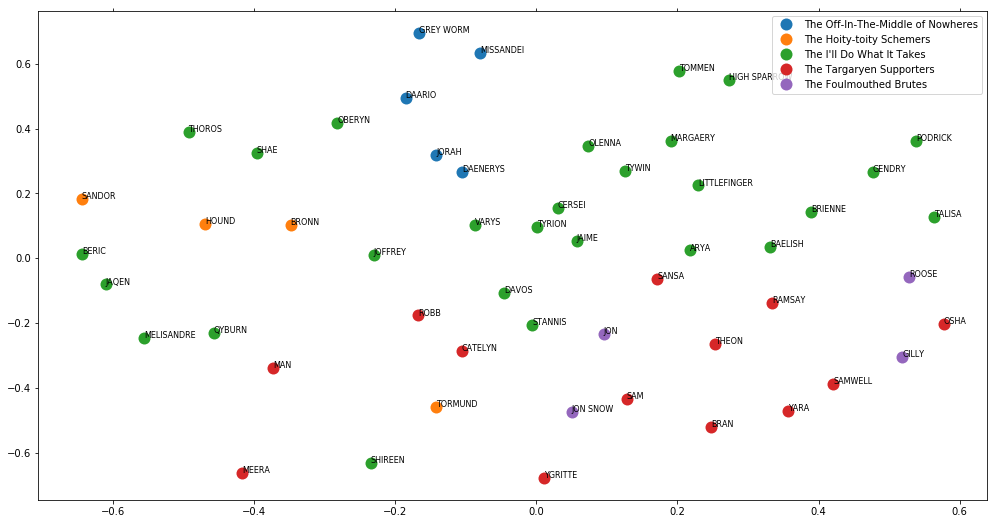

In [13]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up cluster names using a dict
cluster_names = {0: 'The Off-In-The-Middle of Nowheres',
                 1: 'The Hoity-toity Schemers',
                 2: "The I'll Do What It Takes",
                 3: 'The Targaryen Supporters',
                 4: 'The Foulmouthed Brutes'
                }


#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=characters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show()